In [ ]:
from google.colab import files, drive

#uploaded = files.upload()
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [ ]:
!cp /content/drive/'My Drive'/Research_project/all_functions/archs_lether.py ./
!cp /content/drive/'My Drive'/Research_project/all_functions/utils.py ./
!cp /content/drive/'My Drive'/Research_project/all_functions/datasets.py ./
!cp /content/drive/'My Drive'/Research_project/all_functions/dataset.py ./
!cp /content/drive/'My Drive'/Research_project/all_functions/metrics.py ./

# !cp -r /content/drive/'My Drive'/Research_project/leather ./

%ls

archs_lether.py  datasets.py  metrics.py    sample_data/
dataset.py       drive/       __pycache__/  utils.py


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import joblib
from tqdm import tqdm 
#import glob
from glob import glob
import datetime
import cv2 

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.nn import functional as F
#import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torchvision.utils import make_grid

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Research_project/CAVGA/')

from model_GVAE import Encoder, Decod
from data_loader import Data_Loader
# https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/16eddfa055a9c618ba548e9fb4529e2ccbc79c35/src/misc_functions.py#L53


In [ ]:
from dataset import Data_set_loader, data_set_gen
import archs_lether, datasets
from utils import *

In [ ]:
'''
Initilize the Model with Backbone network, dataset, batchsize etc
'''

def parse_args():
    parser = argparse.ArgumentParser()  

    parser.add_argument('--name', default='VAE_GAN', help='model name') 
    parser.add_argument('--arch', default='ResNet18')
    parser.add_argument('--backbone', default='resnet18')
    parser.add_argument('--dataset', default='capsule') # capsule, leather ========== type of Dataset ==========
    parser.add_argument('--metric', default='adacos')
    parser.add_argument('--num-features', default=512, type=int,
                        help='dimention of embedded features')
    parser.add_argument('--num-classes', default=200, type=int)
    parser.add_argument('-b', '--batch-size', default=8, type=int,
                        metavar='N', help='mini-batch size (default: 8)')
    parser.add_argument('--epochs', default=100, type=int)
    parser.add_argument('--lr', '--learning-rate', default=1e-1, type=float)
    parser.add_argument('--min-lr', default=1e-4, type=float)
    parser.add_argument('--momentum', default=0.9, type=float)
    parser.add_argument('--weight-decay', default=1e-4, type=float)
    
    args = parser.parse_args()

    return args

In [ ]:
# for passing arguments
import sys
if sys.argv:
        del sys.argv[1:]

In [ ]:
args = parse_args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

print('Details of System ------------------------')
for arg in vars(args):
    print('%s: %s' % (arg, getattr(args, arg)))
print('----------------------------------------')


criterion = nn.CrossEntropyLoss().to(device)

cudnn.benchmark = True

cuda
Details of System ------------------------
name: VAE_GAN
arch: ResNet18
backbone: resnet18
dataset: capsule
metric: adacos
num_features: 512
num_classes: 200
batch_size: 8
epochs: 100
lr: 0.1
min_lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
----------------------------------------


In [ ]:
if args.dataset == 'capsule':
    base_dir = '/content/drive/My Drive/Research_project/capsule/'
    
    add_dir = 'train/good/'
    img_paths_train_good = glob(base_dir + add_dir + '*.png')
    labels_train_good = [0 for p in img_paths_train_good]
    
    add_dir = 'test/good/'
    img_paths_test_good = glob(base_dir + add_dir + '*.png')
    labels_test_good = [0 for p in img_paths_test_good]
    
    add_dir = 'test/crack/'
    img_paths_test_bad = glob(base_dir + add_dir + '*.png')
    add_dir = 'test/faulty_imprint/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'test/poke/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'test/scratch/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png')) 
    add_dir = 'test/squeeze/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png'))
    labels_test_bad = [1 for p in img_paths_test_bad]

    ## Ground Truth  
    add_dir = 'ground_truth/crack/'
    img_paths_ground_truth = glob(base_dir + add_dir + '*.png')
    add_dir = 'ground_truth/faulty_imprint/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'ground_truth/scratch/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'ground_truth/squeeze/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png')) 
    add_dir = 'ground_truth/poke/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png'))
    
if args.dataset == 'leather':
    base_dir = '/content/drive/My Drive/Research_project/leather/'
    
    add_dir = 'train/good/'
    img_paths_train_good = glob(base_dir + add_dir + '*.png')
    labels_train_good = [0 for p in img_paths_train_good]
    
    add_dir = 'test/good/'
    img_paths_test_good = glob(base_dir + add_dir + '*.png')
    labels_test_good = [0 for p in img_paths_test_good]
    
    add_dir = 'test/color/'
    img_paths_test_bad = glob(base_dir + add_dir + '*.png')
    add_dir = 'test/cut/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'test/fold/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'test/glue/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png')) 
    add_dir = 'test/poke/'
    img_paths_test_bad.extend(glob(base_dir + add_dir + '*.png'))
    labels_test_bad = [1 for p in img_paths_test_bad]

    ## Ground Truth  
    add_dir = 'ground_truth/color/'
    img_paths_ground_truth = glob(base_dir + add_dir + '*.png')
    add_dir = 'ground_truth/cut/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'ground_truth/fold/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png'))
    add_dir = 'ground_truth/glue/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png')) 
    add_dir = 'ground_truth/poke/'
    img_paths_ground_truth.extend(glob(base_dir + add_dir + '*.png'))


In [ ]:
print(len(img_paths_train_good))
print(len(img_paths_test_good))
print(len(img_paths_test_bad))
print(len(labels_train_good))
print(labels_test_good)
print(len(labels_test_bad))

print(len(img_paths_ground_truth))

225
23
109
225
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
109
109


In [ ]:
print(img_paths_ground_truth)
print(img_paths_test_bad)

['/content/drive/My Drive/Research_project/capsule/ground_truth/crack/019_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/014_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/011_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/017_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/021_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/016_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/005_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/004_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/010_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/006_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/013_mask.png', '/content/drive/My Drive/Research_project/capsule/ground_truth/crack/002_ma

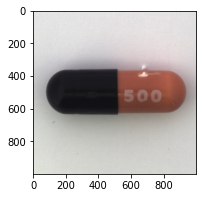

In [ ]:
for i in range(len(img_paths_test_bad)):
    filename = img_paths_test_bad[i]
    test_image = Image.open(filename)  
    plt.figure(figsize=(3,3))
    plt.imshow(test_image)
    break 

In [ ]:
train_img_paths_train_good, test_img_paths_train_good, train_labels_train_good, test_labels_train_good = train_test_split(
    img_paths_train_good, 
    labels_train_good, 
    test_size=0.2, random_state=41, stratify=labels_train_good)

train_img_paths_test_good, test_img_paths_test_good, train_labels_test_good, test_labels_test_good = train_test_split(
    img_paths_test_good, 
    labels_test_good, 
    test_size=0.2, random_state=41, stratify=labels_test_good)

train_img_paths_test_bad, test_img_paths_test_bad, train_labels_test_bad, test_labels_test_bad = train_test_split(
    img_paths_test_bad, 
    labels_test_bad, 
    test_size=0.8, random_state=41, stratify=labels_test_bad)

In [ ]:
train_img_paths = train_img_paths_train_good + train_img_paths_test_good + train_img_paths_test_bad
test_img_paths = test_img_paths_train_good + test_img_paths_test_good + test_img_paths_test_bad

train_labels =  train_labels_train_good + train_labels_test_good + train_labels_test_bad
test_labels =  test_labels_train_good + test_labels_test_good + test_labels_test_bad

In [ ]:
len(train_img_paths)

219

In [ ]:
transform_mvtec_train = transforms.Compose([transforms.Resize((300,300)),
                                      transforms.RandomCrop((256,256)),
                                      #transforms.RandomHorizontalFlip(p=0.5),
                                      #transforms.RandomVerticalFlip(p=0.5),
                                      transforms.ToTensor()])

transform_mvtec_test = transforms.Compose([transforms.Resize((256, 256)),
                                           transforms.ToTensor()])

In [ ]:
    train_set = datasets.MVTec_dataset(
        train_img_paths,
        train_labels,
        transform=transform_mvtec_train)

    test_set = datasets.MVTec_dataset(
        test_img_paths,
        test_labels,
        transform=transform_mvtec_test)

In [ ]:
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0)

    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=0)

In [ ]:
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, input, label=None):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W) # Applies a linear transformation to the incoming data: y = xA^T + b 
        if label is None:
            return logits
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7)) # bring all the point from -1 to 1 
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            # print(B_avg)
            theta_med = torch.median(theta[one_hot == 1])
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        output = self.s * logits

        return output

In [ ]:
from torch.nn import Parameter
metric_fc = AdaCos(num_features=args.num_features, num_classes=args.num_classes).to(device)

In [ ]:
class ResNet_(nn.Module):
    def __init__(self, args):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        last_channels = 512
        #last_channels = 2
        
            
        self.features = nn.Sequential(
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.relu,
            self.backbone.layer1,
            self.backbone.layer2,
            self.backbone.layer3,
            self.backbone.layer4)

        self.bn1 = nn.BatchNorm2d(last_channels)
        self.dropout = nn.Dropout2d(0.5)
        self.fc = nn.Linear(16*16*last_channels, args.num_features)
        #self.fc = nn.Linear(524288, args.num_features)
        self.bn2 = nn.BatchNorm1d(args.num_features)

    def freeze_bn(self):
        for m in self.features.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.requires_grad = False
                m.bias.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = self.bn1(x)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        output = self.bn2(x)

        return output

In [ ]:
class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()

        # encoder ********************************
        self.resnet = ResNet_(args)

        '''self.E_layer1_8 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4,4), stride=2, padding=1),
                                      nn.LeakyReLU(0.2, inplace=True),
                                      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), stride=2, padding=1),
                                      nn.BatchNorm2d(num_features=128),
                                      nn.LeakyReLU(0.2, inplace=True),
                                      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,4), stride=2, padding=1),
                                      nn.BatchNorm2d(num_features=256),
                                      nn.LeakyReLU(0.2, inplace=True),
                                      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4,4), stride=2, padding=1),
                                      nn.BatchNorm2d(num_features=512),
                                      nn.LeakyReLU(0.2, inplace=True),
                                      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4,4), stride=2, padding=1))
        self.E_bn_relu = nn.Sequential(nn.BatchNorm2d(num_features=512),
                                      nn.ReLU(inplace=True))
                                      '''

        
        # *******************************************************

        # decoder
        self.dim = 512*16*16
        self.fc_d = nn.Sequential(
            nn.Linear(args.num_features, self.dim),
            nn.BatchNorm1d(self.dim),
            nn.LeakyReLU(0.2),
        )
        self.decoder = Decod()

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.fc_d(z)
        h = h.view(-1, 512, 16, 16)
        return self.decoder(h)

    def encoder(self, x):
        x = self.resnet(x)   # ouput each = (8,512)
        return x


    def forward(self, x):
        mu, logvar = self.encoder(x), self.encoder(x)   # ouput each = (8,512)
        #print('sizes ---------- ', mu.shape, logvar.shape)
        self.mu = mu
        self.logvar = logvar
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# custom weights initialization called on G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #m.weight.data.normal_(0.0, 0.02)
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    if classname.find('ConvTranspose') != -1:
        #m.weight.data.normal_(0.0, 0.02)
        nn.init.xavier_normal_(m.weight.data)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()

      self.dim = 512*8*8
      self.layer1_13 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4,4), stride=2, padding=1),
          # for gray images
          #nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4,4), stride=2, padding=1),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), stride=2, padding=1),
          nn.BatchNorm2d(num_features=128),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,4), stride=2, padding=1),
          nn.BatchNorm2d(num_features=256),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4,4), stride=2, padding=1),
          nn.BatchNorm2d(num_features=512),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4,4), stride=2, padding=1),
          nn.Sigmoid()
      )
      self.linear = nn.Sequential(nn.Linear(self.dim, 1024),
                                  nn.BatchNorm1d(1024),                    
                                  nn.LeakyReLU(0.2, True),
                                  nn.Linear(1024, 1),
                                  nn.Sigmoid())

    def forward(self, input):
      x = self.layer1_13(input)
      x = x.view(x.size(0), -1)
      #x=x.view(-1, 512*8*8)
      x= self.linear(x)
      return x.squeeze(1)

# --------------------------------------------------------------------------------------

def loss_function(recon_x,x,mean,logstd):
    BCE = F.binary_cross_entropy(recon_x,x,reduction='sum')
   
    # Because var is the natural logarithm of the standard deviation, 
    # first find the natural logarithm and then square it to convert to variance
    var = torch.pow(torch.exp(logstd),2)
    KLD = -0.5 * torch.sum(1+torch.log(var)-torch.pow(mean,2)-var)
    return BCE+KLD

In [ ]:
def vae_gan_train(args, input, vae, D, optimizer ):
    ###################################################################
    #           Initilization
    ###################################################################
    z_dim = 512
    nz=z_dim
    

    #print("Random Seed: 11")
    random.seed(11)
    torch.manual_seed(11)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    data = input.to(device)
    # Can optimize operating efficiency
    cudnn.benchmark = True

    vae = vae.to(device)
    D = D.to(device)

    criterion = nn.BCELoss().to(device)
    MSECriterion = nn.MSELoss().to(device)
    l1_loss = nn.L1Loss()

    #print("=====> Setup optimizer")
    optimizerD = optim.Adam(D.parameters(), lr=0.0001, weight_decay=5e-4)
    optimizerVAE = optim.Adam(vae.parameters(), lr=0.0001, weight_decay=5e-4)

    gen_win = None
    rec_win = None

    ###################################################
    # (2) Update G network which is the decoder of VAE
    ###################################################
    recon_data,mean,logstd = vae(data)
    #print('recon Data =  ',recon_data.shape,'original Data =  ', data.shape)
    vae.zero_grad()
    vae_loss = loss_function(recon_data,data,mean,logstd)
    vae_loss.backward(retain_graph=True)
    optimizerVAE.step()
    
    ###################################################################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###################################################################
    # train with real
    D.zero_grad()
    
    #label = label.to(device)
    batch_size = data.shape[0]
    output = D(data)
    #print("output size of netDs: ", output.size())

    real_label = (torch.ones(batch_size)*0.95).to(device)  # Define the real image label as 1
    fake_label = (torch.ones(batch_size)*0.05).to(device)  # Define the label of the fake picture as 0
    errD_real = criterion(output, real_label)
    errD_real.backward()
    real_data_score = output.mean().item()

    # train with fake, taking the noise vector z as the input of D network
    # Randomly generate a latent variable, and then generate a picture through the decoder
    z = torch.randn(batch_size, nz).to(device)
    # Turn the latent variable z into a fake picture through vae's decoder
    fake_data = vae.decode(z)
    #print(fake_data.shape)
    output = D(fake_data)
    errD_fake = criterion(output, fake_label)
    errD_fake.backward()
    # fake_data_score Used to output the score of the fake photo, 0 is the most false, 1 is true
    fake_data_score = output.data.mean()
    errD = errD_real + errD_fake  # Discriminator Loss
    optimizerD.step()

    ###############################################
    # (3) Update G network: maximize log(D(G(z)))
    ###############################################
    vae.zero_grad()
    real_label = torch.ones(batch_size).to(device)  # Define the real image label as 1
    recon_data,mean,logstd = vae(data)
    output = D(recon_data)
    errVAE = criterion(output, real_label)
    abs_loss = l1_loss(recon_data, data) # Generator Loss
    errVAE.backward()
    D_G_z2 = output.mean().item()
    optimizerD.step()

    ############################################### End of Training Code
        
    D_Losses.append(errD.item())
    G_Losses.append(abs_loss.item())
    
    z = vae.encoder(data)
    return z, real_data_score, fake_data_score, errD.item(), errVAE.item()

In [ ]:
def train(args, train_loader,resN, model,D, metric_fc, criterion, optimizer, epoch):
    losses = AverageMeter()
    acc1s = AverageMeter()
    acc5s = AverageMeter()

    model.train()
    resN.train()
    metric_fc.train()

    for i, (input, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        input = input.to(device)
        target = target.long().to(device) 

        #********************** VAE Training *******************
        z, real_score, fake_score, errD, errVAE = vae_gan_train(args, input, model, D, optimizer )
        #*********************************************

        for i in range(3):
            feature = resN(input)
            output = metric_fc(feature, target)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        losses.update(loss.item(), input.size(0))
        acc1s.update(acc1.item(), input.size(0))
        acc5s.update(acc5.item(), input.size(0))
        E_Losses.append(loss.item())

        # compute gradient and do optimizing step based on Adacos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    log = OrderedDict([
        ('loss', losses.avg),
        ('acc@1', acc1s.avg),
        ('acc@5', acc5s.avg),
    ])

    if epoch %5 == 0:
        x_0,_ = iter(test_loader).next()
        recon_x,_,_ = model(x_0.to(device))
        fake_images = make_grid(recon_x.cpu(), nrow=8, normalize=True).detach()
        plt.imshow(np.transpose((fake_images), [1, 2, 0])[:,:,0:3], interpolation="bicubic")
        plt.show()

        print('real_score: %.4f fake_score: %.4f Loss_D: %.4f errVAE: %4f'
              % (real_score, fake_score, errD, errVAE))

    return log

def validate(args, val_loader,resN, model, metric_fc, criterion):
    losses = AverageMeter()
    acc1s = AverageMeter()
    acc5s = AverageMeter()

    # switch to evaluate mode
    model.eval()
    resN.eval()
    metric_fc.eval()

    with torch.no_grad():
        for i, (input, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
            input = input.to(device)
            target = target.long().to(device) 

            feature = resN(input)
            output = metric_fc(feature)
            loss = criterion(output, target)

            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            losses.update(loss.item(), input.size(0))
            acc1s.update(acc1.item(), input.size(0))
            acc5s.update(acc5.item(), input.size(0))

    log = OrderedDict([
        ('loss', losses.avg),
        ('acc@1', acc1s.avg),
        ('acc@5', acc5s.avg),
    ])

    return log

In [ ]:
D = Discriminator()
model = VAE(args)
resN = ResNet_(args)
model = model.to(device)
D = D.to(device)
resN = resN.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/28 [00:00<?, ?it/s]

Epoch [1/100]


100%|██████████| 28/28 [02:14<00:00,  4.81s/it]


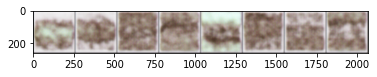

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.5912 fake_score: 0.5877 Loss_D: 1.7167 errVAE: 0.504634


100%|██████████| 18/18 [00:55<00:00,  3.07s/it]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


loss 3.0973 - acc@1 68.9498 - acc@5 73.5160 - val_loss 5.8008 - val_acc@1 0.0000 - val_acc@5 0.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [2/100]


100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


loss 2.5740 - acc@1 75.3425 - acc@5 80.3653 - val_loss 4.9150 - val_acc@1 63.7681 - val_acc@5 63.7681


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [3/100]


100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


loss 2.2215 - acc@1 80.3653 - acc@5 82.1918 - val_loss 4.8585 - val_acc@1 63.7681 - val_acc@5 83.3333


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [4/100]


100%|██████████| 18/18 [00:08<00:00,  2.25it/s]


loss 2.0700 - acc@1 79.9087 - acc@5 85.3881 - val_loss 4.7429 - val_acc@1 63.7681 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [5/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.9305 - acc@1 79.9087 - acc@5 87.2146 - val_loss 4.7562 - val_acc@1 63.7681 - val_acc@5 100.0000
Epoch [6/100]


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


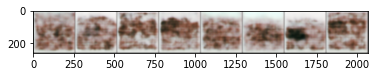

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.5868 fake_score: 0.5265 Loss_D: 1.7399 errVAE: 0.541367


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.8467 - acc@1 79.9087 - acc@5 87.6712 - val_loss 4.7521 - val_acc@1 61.5942 - val_acc@5 100.0000
Epoch [7/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.9359 - acc@1 74.8858 - acc@5 84.4749 - val_loss 4.7510 - val_acc@1 42.0290 - val_acc@5 100.0000
Epoch [8/100]


100%|██████████| 18/18 [00:07<00:00,  2.27it/s]


loss 1.7338 - acc@1 80.3653 - acc@5 88.1279 - val_loss 4.7424 - val_acc@1 36.2319 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [9/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.6431 - acc@1 80.3653 - acc@5 88.5845 - val_loss 4.7433 - val_acc@1 36.2319 - val_acc@5 100.0000
Epoch [10/100]


100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


loss 1.5635 - acc@1 80.3653 - acc@5 88.1279 - val_loss 4.7364 - val_acc@1 36.2319 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [11/100]


100%|██████████| 28/28 [00:55<00:00,  1.98s/it]


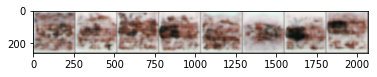

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.5449 fake_score: 0.5124 Loss_D: 1.6272 errVAE: 0.605587


100%|██████████| 18/18 [00:08<00:00,  2.25it/s]


loss 1.4848 - acc@1 80.3653 - acc@5 88.5845 - val_loss 4.7337 - val_acc@1 36.2319 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [12/100]


100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


loss 1.4951 - acc@1 77.6256 - acc@5 95.8904 - val_loss 4.7181 - val_acc@1 39.1304 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [13/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.3154 - acc@1 80.3653 - acc@5 99.0868 - val_loss 4.7210 - val_acc@1 36.9565 - val_acc@5 100.0000
Epoch [14/100]


100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


loss 1.2627 - acc@1 81.2785 - acc@5 99.5434 - val_loss 4.7154 - val_acc@1 36.2319 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [15/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.1984 - acc@1 88.5845 - acc@5 99.0868 - val_loss 4.7161 - val_acc@1 36.9565 - val_acc@5 100.0000
Epoch [16/100]


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


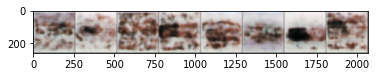

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.5099 fake_score: 0.5262 Loss_D: 2.1023 errVAE: 0.650113


100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


loss 1.1564 - acc@1 89.9543 - acc@5 99.0868 - val_loss 4.7123 - val_acc@1 36.9565 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [17/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.1970 - acc@1 89.9543 - acc@5 98.6301 - val_loss 4.7278 - val_acc@1 36.9565 - val_acc@5 100.0000
Epoch [18/100]


100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


loss 1.1010 - acc@1 90.4110 - acc@5 99.0868 - val_loss 4.7094 - val_acc@1 36.9565 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [19/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0879 - acc@1 89.9543 - acc@5 99.5434 - val_loss 4.7158 - val_acc@1 36.2319 - val_acc@5 100.0000
Epoch [20/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0572 - acc@1 89.9543 - acc@5 98.6301 - val_loss 4.7449 - val_acc@1 36.2319 - val_acc@5 99.2754
Epoch [21/100]


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


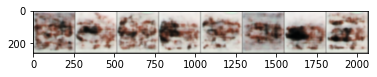

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.6090 fake_score: 0.5285 Loss_D: 1.3749 errVAE: 0.585441


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0430 - acc@1 90.4110 - acc@5 99.0868 - val_loss 4.7266 - val_acc@1 36.9565 - val_acc@5 100.0000
Epoch [22/100]


100%|██████████| 18/18 [00:08<00:00,  2.24it/s]


loss 1.1100 - acc@1 90.4110 - acc@5 98.6301 - val_loss 4.7090 - val_acc@1 36.2319 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [23/100]


100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


loss 1.0487 - acc@1 90.8676 - acc@5 99.0868 - val_loss 4.7037 - val_acc@1 36.2319 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [24/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0149 - acc@1 90.8676 - acc@5 99.5434 - val_loss 4.7173 - val_acc@1 36.2319 - val_acc@5 100.0000
Epoch [25/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0032 - acc@1 90.8676 - acc@5 99.5434 - val_loss 4.7636 - val_acc@1 36.2319 - val_acc@5 100.0000
Epoch [26/100]


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


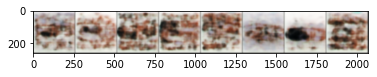

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.5897 fake_score: 0.5562 Loss_D: 1.9704 errVAE: 1.092676


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0062 - acc@1 91.3242 - acc@5 99.0868 - val_loss 4.7774 - val_acc@1 36.9565 - val_acc@5 97.1014
Epoch [27/100]


100%|██████████| 18/18 [00:07<00:00,  2.25it/s]


loss 1.0704 - acc@1 90.4110 - acc@5 99.0868 - val_loss 4.6603 - val_acc@1 41.3043 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [28/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9943 - acc@1 91.7808 - acc@5 100.0000 - val_loss 4.7624 - val_acc@1 36.2319 - val_acc@5 100.0000
Epoch [29/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9988 - acc@1 91.3242 - acc@5 99.0868 - val_loss 5.0103 - val_acc@1 36.2319 - val_acc@5 42.7536
Epoch [30/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9830 - acc@1 92.2374 - acc@5 100.0000 - val_loss 4.7198 - val_acc@1 37.6812 - val_acc@5 98.5507
Epoch [31/100]


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


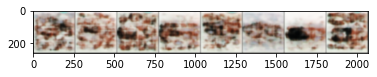

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.5340 fake_score: 0.5069 Loss_D: 1.6386 errVAE: 0.478578


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9848 - acc@1 92.2374 - acc@5 100.0000 - val_loss 4.6643 - val_acc@1 43.4783 - val_acc@5 100.0000
Epoch [32/100]


100%|██████████| 18/18 [00:07<00:00,  2.25it/s]


loss 1.0706 - acc@1 89.9543 - acc@5 99.5434 - val_loss 4.6584 - val_acc@1 43.4783 - val_acc@5 100.0000


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [33/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0139 - acc@1 91.3242 - acc@5 100.0000 - val_loss 4.8222 - val_acc@1 36.2319 - val_acc@5 93.4783
Epoch [34/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9776 - acc@1 91.7808 - acc@5 100.0000 - val_loss 4.9320 - val_acc@1 36.2319 - val_acc@5 60.8696
Epoch [35/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9772 - acc@1 92.2374 - acc@5 100.0000 - val_loss 4.8590 - val_acc@1 36.2319 - val_acc@5 75.3623
Epoch [36/100]


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


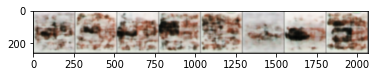

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.6668 fake_score: 0.5246 Loss_D: 1.2427 errVAE: 0.577612


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9530 - acc@1 92.2374 - acc@5 100.0000 - val_loss 4.8473 - val_acc@1 36.2319 - val_acc@5 76.8116
Epoch [37/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0427 - acc@1 90.4110 - acc@5 98.6301 - val_loss 4.9505 - val_acc@1 36.2319 - val_acc@5 44.9275
Epoch [38/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0073 - acc@1 91.3242 - acc@5 99.5434 - val_loss 4.7433 - val_acc@1 36.9565 - val_acc@5 99.2754
Epoch [39/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9620 - acc@1 92.6941 - acc@5 100.0000 - val_loss 4.7977 - val_acc@1 36.9565 - val_acc@5 88.4058
Epoch [40/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9509 - acc@1 92.6941 - acc@5 100.0000 - val_loss 4.9513 - val_acc@1 36.2319 - val_acc@5 50.0000
Epoch [41/100]


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


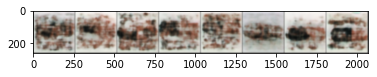

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.6922 fake_score: 0.4845 Loss_D: 1.5488 errVAE: 0.470815


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9407 - acc@1 92.6941 - acc@5 100.0000 - val_loss 4.6756 - val_acc@1 42.7536 - val_acc@5 100.0000
Epoch [42/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0257 - acc@1 90.8676 - acc@5 99.0868 - val_loss 5.0344 - val_acc@1 36.2319 - val_acc@5 36.9565
Epoch [43/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9722 - acc@1 92.2374 - acc@5 100.0000 - val_loss 4.8343 - val_acc@1 36.2319 - val_acc@5 81.1594
Epoch [44/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9478 - acc@1 93.6073 - acc@5 100.0000 - val_loss 4.7915 - val_acc@1 36.2319 - val_acc@5 92.7536
Epoch [45/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9301 - acc@1 93.1507 - acc@5 100.0000 - val_loss 4.8032 - val_acc@1 36.9565 - val_acc@5 89.8551
Epoch [46/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


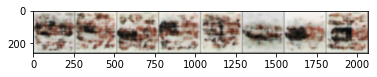

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.6970 fake_score: 0.5286 Loss_D: 1.2866 errVAE: 0.371749


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9144 - acc@1 93.6073 - acc@5 100.0000 - val_loss 4.6961 - val_acc@1 39.8551 - val_acc@5 100.0000
Epoch [47/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0083 - acc@1 91.3242 - acc@5 99.0868 - val_loss 4.7874 - val_acc@1 39.1304 - val_acc@5 84.0580
Epoch [48/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9735 - acc@1 92.6941 - acc@5 100.0000 - val_loss 4.8472 - val_acc@1 36.2319 - val_acc@5 84.0580
Epoch [49/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9381 - acc@1 93.6073 - acc@5 100.0000 - val_loss 5.0021 - val_acc@1 36.2319 - val_acc@5 37.6812
Epoch [50/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9174 - acc@1 93.6073 - acc@5 100.0000 - val_loss 4.8047 - val_acc@1 36.2319 - val_acc@5 92.7536
Epoch [51/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


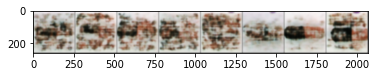

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.6770 fake_score: 0.5525 Loss_D: 1.5521 errVAE: 0.483793


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9082 - acc@1 94.0639 - acc@5 100.0000 - val_loss 4.7755 - val_acc@1 36.2319 - val_acc@5 97.8261
Epoch [52/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0182 - acc@1 90.8676 - acc@5 99.0868 - val_loss 4.7131 - val_acc@1 42.0290 - val_acc@5 96.3768
Epoch [53/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9935 - acc@1 92.2374 - acc@5 99.5434 - val_loss 4.7135 - val_acc@1 37.6812 - val_acc@5 99.2754
Epoch [54/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9369 - acc@1 93.6073 - acc@5 100.0000 - val_loss 4.8014 - val_acc@1 36.2319 - val_acc@5 93.4783
Epoch [55/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9047 - acc@1 94.0639 - acc@5 100.0000 - val_loss 4.8549 - val_acc@1 36.2319 - val_acc@5 73.9130
Epoch [56/100]


100%|██████████| 28/28 [00:54<00:00,  1.96s/it]


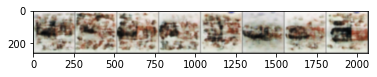

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7189 fake_score: 0.5234 Loss_D: 1.7216 errVAE: 0.410644


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8938 - acc@1 94.5205 - acc@5 100.0000 - val_loss 4.6600 - val_acc@1 44.9275 - val_acc@5 100.0000
Epoch [57/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 1.0048 - acc@1 91.3242 - acc@5 99.0868 - val_loss 4.7036 - val_acc@1 42.0290 - val_acc@5 99.2754
Epoch [58/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9623 - acc@1 92.2374 - acc@5 100.0000 - val_loss 4.6880 - val_acc@1 42.7536 - val_acc@5 99.2754
Epoch [59/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9338 - acc@1 93.1507 - acc@5 100.0000 - val_loss 4.7468 - val_acc@1 36.2319 - val_acc@5 98.5507
Epoch [60/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8984 - acc@1 94.0639 - acc@5 100.0000 - val_loss 4.7586 - val_acc@1 37.6812 - val_acc@5 97.8261
Epoch [61/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


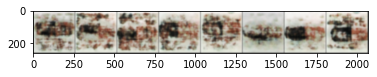

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7457 fake_score: 0.5720 Loss_D: 1.5402 errVAE: 0.418951


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8869 - acc@1 94.5205 - acc@5 100.0000 - val_loss 4.7924 - val_acc@1 36.2319 - val_acc@5 93.4783
Epoch [62/100]


100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


loss 0.9882 - acc@1 90.8676 - acc@5 98.6301 - val_loss 4.5670 - val_acc@1 73.1884 - val_acc@5 99.2754


  0%|          | 0/28 [00:00<?, ?it/s]

=> saved best model
Epoch [63/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9372 - acc@1 92.2374 - acc@5 100.0000 - val_loss 4.8910 - val_acc@1 36.2319 - val_acc@5 68.1159
Epoch [64/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9135 - acc@1 93.6073 - acc@5 100.0000 - val_loss 4.7336 - val_acc@1 36.9565 - val_acc@5 98.5507
Epoch [65/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8781 - acc@1 94.9772 - acc@5 100.0000 - val_loss 4.7934 - val_acc@1 36.2319 - val_acc@5 90.5797
Epoch [66/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


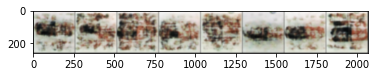

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7457 fake_score: 0.5540 Loss_D: 1.3677 errVAE: 0.342496


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8647 - acc@1 94.9772 - acc@5 100.0000 - val_loss 4.7720 - val_acc@1 36.2319 - val_acc@5 97.1014
Epoch [67/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9857 - acc@1 91.7808 - acc@5 98.6301 - val_loss 4.6079 - val_acc@1 56.5217 - val_acc@5 99.2754
Epoch [68/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9016 - acc@1 94.5205 - acc@5 100.0000 - val_loss 4.7783 - val_acc@1 36.2319 - val_acc@5 94.2029
Epoch [69/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8730 - acc@1 94.0639 - acc@5 100.0000 - val_loss 4.7314 - val_acc@1 38.4058 - val_acc@5 98.5507
Epoch [70/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8588 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7710 - val_acc@1 36.9565 - val_acc@5 94.2029
Epoch [71/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


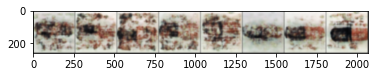

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7734 fake_score: 0.5997 Loss_D: 1.6959 errVAE: 0.299976


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8490 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7517 - val_acc@1 36.9565 - val_acc@5 97.8261
Epoch [72/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9499 - acc@1 92.6941 - acc@5 99.0868 - val_loss 4.6556 - val_acc@1 55.7971 - val_acc@5 99.2754
Epoch [73/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8906 - acc@1 94.9772 - acc@5 100.0000 - val_loss 4.7709 - val_acc@1 36.9565 - val_acc@5 92.7536
Epoch [74/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8595 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7159 - val_acc@1 39.8551 - val_acc@5 98.5507
Epoch [75/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8455 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7697 - val_acc@1 36.9565 - val_acc@5 94.2029
Epoch [76/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


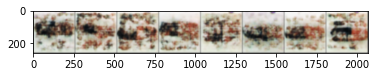

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7664 fake_score: 0.5668 Loss_D: 1.3594 errVAE: 0.529283


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8404 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7473 - val_acc@1 37.6812 - val_acc@5 97.8261
Epoch [77/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.9220 - acc@1 92.6941 - acc@5 100.0000 - val_loss 4.6680 - val_acc@1 52.8986 - val_acc@5 98.5507
Epoch [78/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8657 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7665 - val_acc@1 36.9565 - val_acc@5 93.4783
Epoch [79/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8424 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7178 - val_acc@1 42.7536 - val_acc@5 98.5507
Epoch [80/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8319 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7533 - val_acc@1 37.6812 - val_acc@5 96.3768
Epoch [81/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


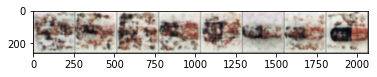

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7957 fake_score: 0.5912 Loss_D: 1.5441 errVAE: 0.292439


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8324 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7341 - val_acc@1 37.6812 - val_acc@5 98.5507
Epoch [82/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8952 - acc@1 93.1507 - acc@5 100.0000 - val_loss 4.6682 - val_acc@1 51.4493 - val_acc@5 99.2754
Epoch [83/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8485 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7360 - val_acc@1 39.1304 - val_acc@5 95.6522
Epoch [84/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8319 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7252 - val_acc@1 41.3043 - val_acc@5 97.1014
Epoch [85/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8249 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7340 - val_acc@1 39.8551 - val_acc@5 97.1014
Epoch [86/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


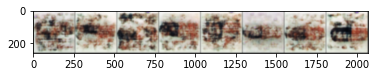

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7601 fake_score: 0.5751 Loss_D: 1.3817 errVAE: 0.238874


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8248 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7257 - val_acc@1 40.5797 - val_acc@5 97.8261
Epoch [87/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8773 - acc@1 94.0639 - acc@5 100.0000 - val_loss 4.7060 - val_acc@1 47.1014 - val_acc@5 94.9275
Epoch [88/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8271 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7210 - val_acc@1 43.4783 - val_acc@5 97.8261
Epoch [89/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8228 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7263 - val_acc@1 42.0290 - val_acc@5 96.3768
Epoch [90/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8192 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7249 - val_acc@1 42.7536 - val_acc@5 96.3768
Epoch [91/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


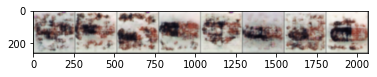

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.8048 fake_score: 0.5390 Loss_D: 1.4075 errVAE: 0.406425


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8176 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7248 - val_acc@1 43.4783 - val_acc@5 97.1014
Epoch [92/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8600 - acc@1 94.5205 - acc@5 100.0000 - val_loss 4.7172 - val_acc@1 44.2029 - val_acc@5 94.2029
Epoch [93/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8180 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7154 - val_acc@1 44.2029 - val_acc@5 97.1014
Epoch [94/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8164 - acc@1 95.8904 - acc@5 100.0000 - val_loss 4.7207 - val_acc@1 42.7536 - val_acc@5 97.1014
Epoch [95/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8156 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7211 - val_acc@1 42.7536 - val_acc@5 96.3768
Epoch [96/100]


100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


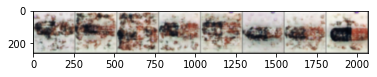

  0%|          | 0/18 [00:00<?, ?it/s]

real_score: 0.7968 fake_score: 0.5441 Loss_D: 1.3512 errVAE: 0.279698


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8149 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7211 - val_acc@1 42.7536 - val_acc@5 96.3768
Epoch [97/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8511 - acc@1 94.9772 - acc@5 100.0000 - val_loss 4.7241 - val_acc@1 44.9275 - val_acc@5 93.4783
Epoch [98/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8151 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7183 - val_acc@1 44.2029 - val_acc@5 96.3768
Epoch [99/100]


  0%|          | 0/28 [00:00<?, ?it/s]

loss 0.8149 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7187 - val_acc@1 44.2029 - val_acc@5 96.3768
Epoch [100/100]


100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


loss 0.8147 - acc@1 96.3470 - acc@5 100.0000 - val_loss 4.7190 - val_acc@1 44.2029 - val_acc@5 96.3768


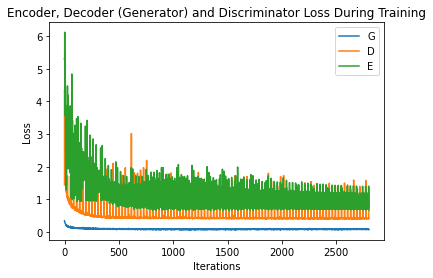

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resN.parameters()), lr=args.lr,
                          momentum=args.momentum, weight_decay=args.weight_decay)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                            T_max=args.epochs, eta_min=args.min_lr)

log = pd.DataFrame(index=[], columns=[
      'epoch', 'lr', 'loss', 'acc@1', 'acc@5', 'val_loss', 'val_acc1', 'val_acc5'
    ])

best_loss = float('inf')

D_Losses = []
G_Losses = []
E_Losses = []

for epoch in range(args.epochs):
    print('Epoch [%d/%d]' % (epoch + 1, args.epochs))

    scheduler.step()

    # train for one epoch
    train_log = train(args, train_loader, resN, model,D, metric_fc, criterion, optimizer, epoch)
    # evaluate on validation set
    val_log = validate(args, test_loader,resN, model, metric_fc, criterion)

    print('loss %.4f - acc@1 %.4f - acc@5 %.4f - val_loss %.4f - val_acc@1 %.4f - val_acc@5 %.4f'
            %(train_log['loss'], train_log['acc@1'], train_log['acc@5'], val_log['loss'], val_log['acc@1'], val_log['acc@5']))

    tmp = pd.Series([
            epoch,
            scheduler.get_lr()[0],
            train_log['loss'],
            train_log['acc@1'],
            train_log['acc@5'],
            val_log['loss'],
            val_log['acc@1'],
            val_log['acc@5'],
        ], index=['epoch', 'lr', 'loss', 'acc@1', 'acc@5', 'val_loss', 'val_acc1', 'val_acc5'])

    log = log.append(tmp, ignore_index=True)

    if val_log['loss'] < best_loss:
        torch.save(model.state_dict(), '/content/drive/My Drive/Research_project/saved_models/vae_model_best_capsule.pt')
        torch.save(D.state_dict(), '/content/drive/My Drive/Research_project/saved_models/D_model_best1_capsule.pt')
        best_loss = val_log['loss']
        print("=> saved best model")

plt.title("Encoder, Decoder (Generator) and Discriminator Loss During Training")
plt.plot(G_Losses, label = "G")
plt.plot(D_Losses, label = "D")
plt.plot(E_Losses, label = "E")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/Research_project/saved_models/vae_model_best_capsule.pt'))


<All keys matched successfully>

In [ ]:
def plot_tSNE(X, y):
  plt.figure(figsize=(8, 6))
      
  # clean the figure
  plt.clf()

  tsne = TSNE()
  X_embedded = tsne.fit_transform(X)
  cmap = ['#00FFFF','#DEB887', '#B8860B','#ffa58f','#ff5f24']
  for idx in range(2):
    plt.scatter(X_embedded[(y==idx), 0], X_embedded[(y==idx), 1], c=cmap[idx], label=idx)

  plt.legend(mvtec_classes, ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.xticks(())
  plt.yticks(())

  plt.show()     

In [ ]:
def plot_tSNE_MVtec(model, metric_fc, train_loader):
  with torch.no_grad():
    model = model.cpu()
    metric_fc = metric_fc.cpu()
    _i = 0
    model.eval()
    for ii, data in enumerate(train_loader):
        _i = _i + 1
        #print(_i)
        data_input, label = data
        
        feature = model(data_input)
        ctgr = metric_fc(feature)
        ctgr = ctgr.argmax(dim=1)
        if _i == 1:
            plt_arc_x = feature
            plt_arc_y = label
            plt_arc_ctgr = ctgr
        else:
            plt_arc_x = torch.cat([plt_arc_x, feature], dim=0)
            plt_arc_y = torch.cat([plt_arc_y, label], dim=0)
            plt_arc_ctgr = torch.cat([plt_arc_ctgr, ctgr], dim=0)

    X = plt_arc_x.cpu().detach().numpy() 
    y = plt_arc_y.cpu().detach().numpy()
    plot_tSNE(X, y)

    plt_arc_df = pd.DataFrame({'label': plt_arc_y})
    plt_arc_df['ctgr'] = plt_arc_ctgr

    X_train=X
    y_train=y
    return X, y, plt_arc_df

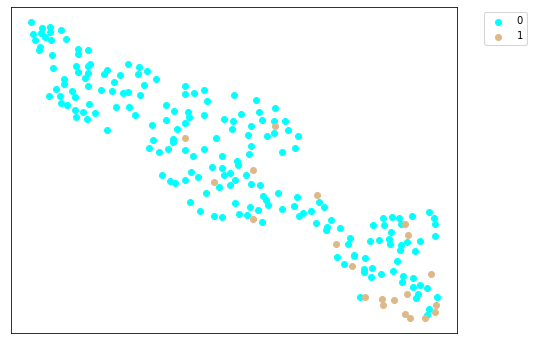

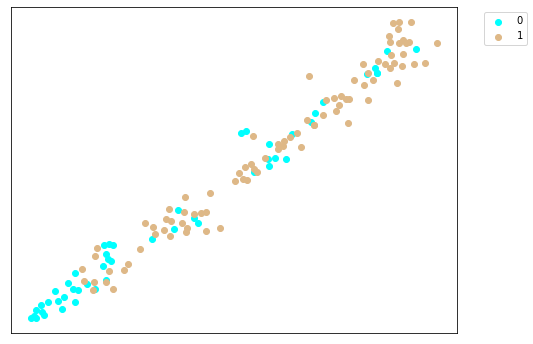

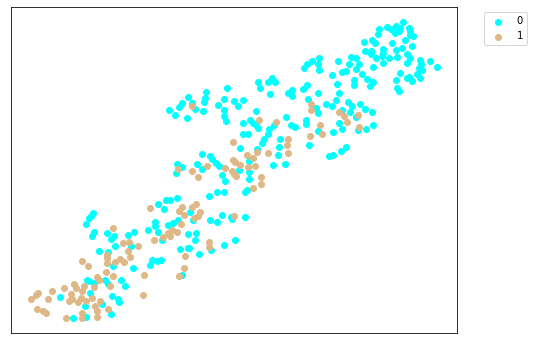

In [ ]:
mvtec_classes = []
for i in range(5):
    mvtec_classes.append(str(i))

X_train, y_train, plt_arc_df_train = plot_tSNE_MVtec(resN, metric_fc, train_loader)
X_test, y_test, plt_arc_df_test = plot_tSNE_MVtec(resN, metric_fc, test_loader)
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
plot_tSNE(X, y)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class My_BasicBlock(nn.Module):
    expansion = 1
    med_out = None
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(My_BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, width, stride, groups, dilation)
        self.bn1 = norm_layer(width)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        My_BasicBlock.med_out = out
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
      
    @classmethod
    def get_med_out(cls):
        return cls.med_out

In [ ]:
list(model.resnet.children())[1][6][1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
list(model.resnet.children())[1][6][1] = My_BasicBlock(512, 512)


params = torch.load('/content/drive/My Drive/Research_project/saved_models/vae_model_best_capsule.pt')
model.load_state_dict(params)

<All keys matched successfully>

In [ ]:
    transform_test_bad = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

In [ ]:
train_test_set_bad = datasets.MVTec_dataset(
        train_img_paths_test_bad,
        train_labels_test_bad,
        transform=transform_test_bad)    

test_test_set_bad = datasets.MVTec_dataset(
        test_img_paths_test_bad,
        test_labels_test_bad,
        transform=transform_test_bad) 

In [ ]:
train_test_bad_loader = DataLoader(train_test_set_bad, batch_size=len(train_test_set_bad))
train_test_bad_dataset_array = next(iter(train_test_bad_loader))[0].numpy()
train_test_bad_dataset_tensor = torch.from_numpy(train_test_bad_dataset_array)

test_test_bad_loader = DataLoader( test_test_set_bad, batch_size=len( test_test_set_bad))
test_test_bad_dataset_array = next(iter( test_test_bad_loader))[0].numpy()
test_test_bad_dataset_tensor = torch.from_numpy( test_test_bad_dataset_array)

In [ ]:
print(train_test_bad_dataset_array.shape)
print(train_test_bad_dataset_tensor.shape)
print(test_test_bad_dataset_array.shape)
print(test_test_bad_dataset_tensor.shape)

(21, 3, 256, 256)
torch.Size([21, 3, 256, 256])
(88, 3, 256, 256)
torch.Size([88, 3, 256, 256])


## GradCam

In [ ]:
def Grad_Cam_Leather(train_test_bad_dataset_tensor, train_img_paths_test_bad):
  for i in range(len(train_test_bad_dataset_tensor)):
    print(train_img_paths_test_bad[i])
    img = train_test_bad_dataset_tensor[i]
    original_img = img  #To display image at last
    img = img.unsqueeze(0)
    model.eval()
    metric_fc.eval()
    
    temp_output = model.encoder(img)
    output = metric_fc(temp_output)
    #print(output)
    class_label = output.argmax(dim=1).item()
    class_score = output[0][1]
    med_out = My_BasicBlock.get_med_out()
    N, C, H, W = med_out.shape
    grads = torch.autograd.grad(class_score, med_out)
    w  = grads[0][0].mean(-1).mean(-1) #Calculate the weight by averaging the gradient for each channel
    ans = torch.matmul(w, med_out.view(C, H*W))
    ans = F.relu(ans)
    ans = ans.view(H, W).cpu().detach().numpy()
    plt.imshow(ans)
    ans = cv2.resize(ans, (256, 256))
    plt.imshow(original_img.permute(1, 2, 0))
    plt.show()
    plt.imshow(original_img.permute(1, 2, 0))
    plt.imshow(ans, alpha=0.5, cmap='jet')
    plt.show()
    if i == 5:
      break
    

/content/drive/My Drive/Research_project/capsule/test/squeeze/008.png


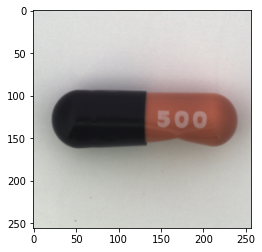

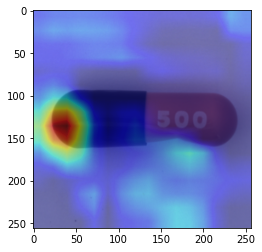

/content/drive/My Drive/Research_project/capsule/test/scratch/010.png


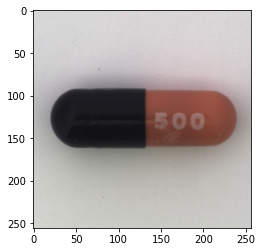

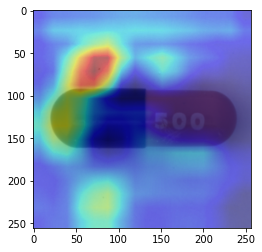

/content/drive/My Drive/Research_project/capsule/test/faulty_imprint/003.png


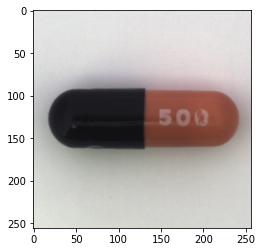

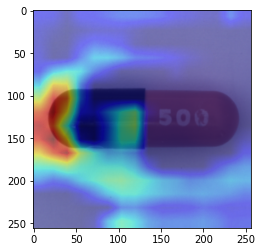

/content/drive/My Drive/Research_project/capsule/test/squeeze/010.png


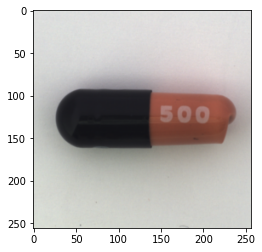

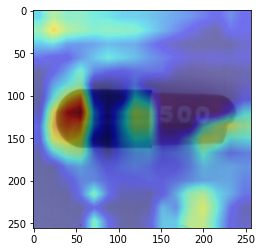

/content/drive/My Drive/Research_project/capsule/test/faulty_imprint/014.png


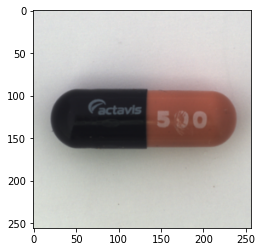

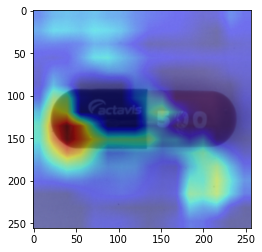

/content/drive/My Drive/Research_project/capsule/test/crack/001.png


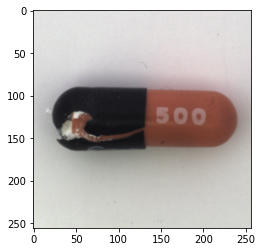

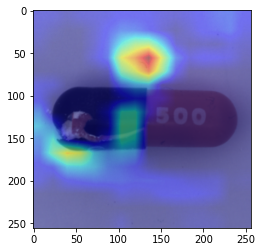

In [ ]:
model.cpu()
Grad_Cam_Leather(train_test_bad_dataset_tensor, train_img_paths_test_bad)

/content/drive/My Drive/Research_project/capsule/test/squeeze/005.png


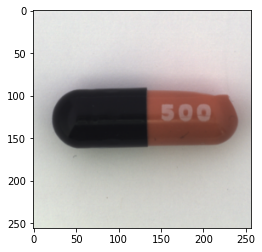

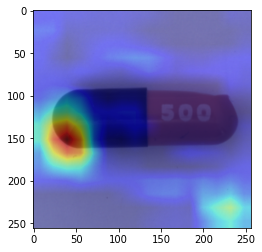

/content/drive/My Drive/Research_project/capsule/test/scratch/008.png


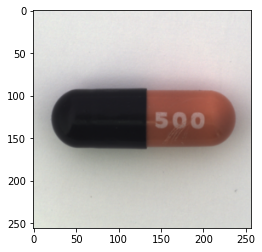

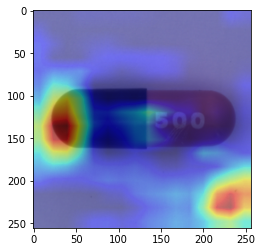

/content/drive/My Drive/Research_project/capsule/test/faulty_imprint/017.png


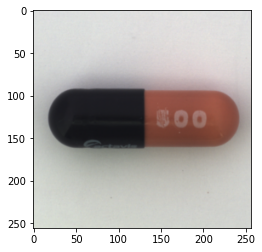

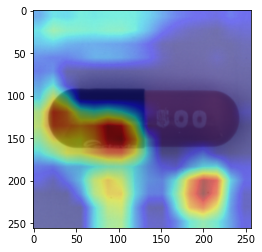

/content/drive/My Drive/Research_project/capsule/test/scratch/021.png


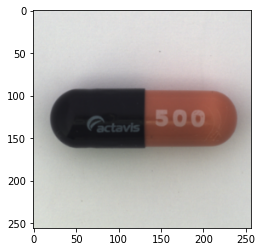

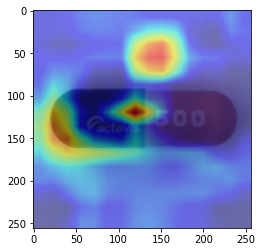

/content/drive/My Drive/Research_project/capsule/test/squeeze/014.png


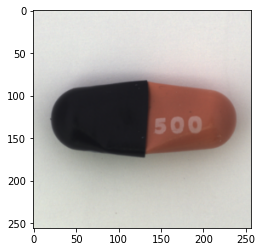

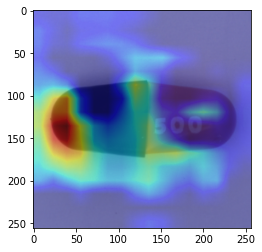

/content/drive/My Drive/Research_project/capsule/test/poke/012.png


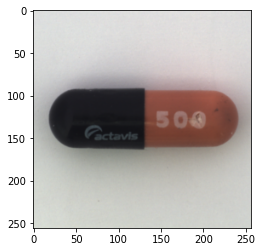

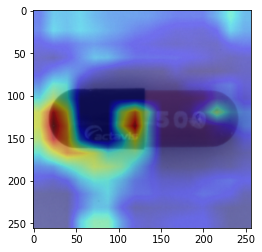

In [ ]:
Grad_Cam_Leather(test_test_bad_dataset_tensor, test_img_paths_test_bad)

In [ ]:
print(ans)

NameError: ignored